In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from copy import deepcopy as copy
from disp import get_ordered_colors
from functools import partial

plt.rc('font', family='serif')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2.0


In [4]:
def compute_current(t, tau, a, tau_m):
    prod_tau = tau * tau_m
    return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)

def find_threshold_points(tau, a, tau_m, b):
    def f(t):
        v = compute_current(t, tau, a, tau_m) - b
        return v
    
    solns = []
    for s in [0.001, 0.005, 0.01, 0.0175, 0.025, 0.0375, 0.05, 0.075, 0.1, 0.3]:   
        soln = fsolve(f, s)
        if len(soln) > 0 and soln[0] > 0 and not np.isclose(soln[0], s, atol=1e-5):
            solns.append(soln[0])
            
    if len(solns) == 0:
        return 0, 0

    t_0 = np.min(solns)
    t_1 = np.max(solns)
    
    return t_0, t_1

def compute_first_moment(tau, a, tau_m, b):
    v_max = np.max(compute_current(np.linspace(0, 0.05, 100), tau, a, tau_m))
    if v_max < b:
        return 0, 0
    
    t_0, t_1 = find_threshold_points(tau, a, tau_m, b)
    
    if np.isclose(t_0, t_1, atol=1e-5):
        return 0, 0
    
    pre =  a * tau * tau_m / (np.square(tau - tau_m))
    term_1 =   np.exp(-t_0 / tau) * (tau * (tau + t_0) - tau_m * (2 * tau + t_0))
    term_2 = - np.exp(-t_1 / tau) * (tau * (tau + t_1) - tau_m * (2 * tau + t_1))
    
    total = pre * (term_1 + term_2 + np.square(tau_m) * (np.exp(-t_0 / tau_m) - np.exp(-t_1 / tau_m))) - b * (t_1 - t_0)
    return total, v_max - b

0.012606320127361941 0.025058112161273433


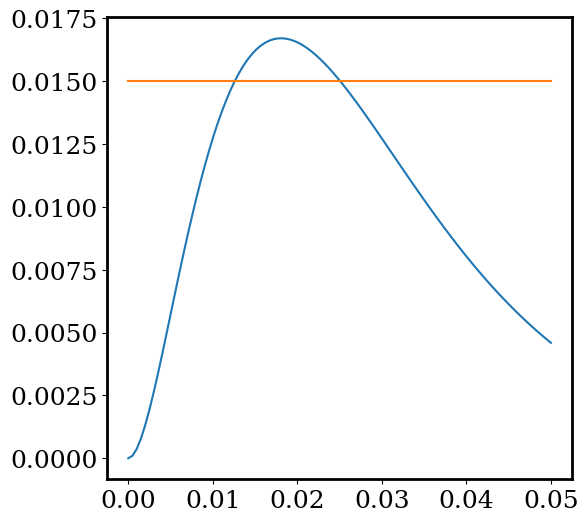

In [5]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
t = np.linspace(0, 0.05, 100)

tau = 12e-3
a = 10
tau_m = 5e-3
b = 0.015

axs.plot(t, compute_current(t, tau, a, tau_m))
axs.plot(t, np.ones_like(t) * b)

t_0, t_1 = find_threshold_points(tau, a, tau_m, b)
print(t_0, t_1)

In [4]:
m_in = np.linspace(1e-4, 0.25, 200)
a = np.linspace(1, 500, 200)
tau_m = 5e-3
b = 0.01

m = np.zeros((200, 200))
peak = np.zeros((200, 200))

all_v = []

moment_locked_mask = np.zeros((200, 200))

for i, m_i in enumerate(m_in):
    for j, a_j in enumerate(a):
        tau_i = m_i / a_j
        m[i, j], peak[i, j] = compute_first_moment(tau_i, a_j, tau_m, b)
        m[i, j] = np.maximum(m[i, j], 0)

        if m[i, j] > 0.0005 * 0.99 and m[i, j] < 0.0005 * 1.01:
            m[i, j] = -0.0005
            moment_locked_mask[i, j] = 1
            
            v = np.maximum(compute_current(np.linspace(0, 0.05, 100), tau_i, a_j, tau_m) - b, 0)
            all_v.append(v)
         
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'$m_0$ out')

cbar = axs.matshow(m, cmap='RdBu', vmax=np.max(m), vmin=-np.max(m))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'peak out')

peak[~(moment_locked_mask.astype(bool))] = 0

cbar = axs.matshow(peak, cmap='RdBu_r', vmax=np.max(peak), vmin=-np.max(peak))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
t = np.linspace(0, 0.1, 100)
for v in all_v:
    axs.plot(t, v)



KeyboardInterrupt



In [ ]:
m_in = np.linspace(1e-4, 0.25, 200)
a = np.linspace(1, 500, 200)
tau_m = 5e-3
b = 0.015

m = np.zeros((200, 200))
peak = np.zeros((200, 200))

all_v = []

moment_locked_mask = np.zeros((200, 200))

for i, m_i in enumerate(m_in):
    for j, a_j in enumerate(a):
        tau_i = m_i / a_j
        m[i, j], peak[i, j] = compute_first_moment(tau_i, a_j, tau_m, b)
        m[i, j] = np.maximum(m[i, j], 0)

        if m[i, j] > 0.0005 * 0.99 and m[i, j] < 0.0005 * 1.01:
            m[i, j] = -0.0005
            moment_locked_mask[i, j] = 1
            
            v = np.maximum(compute_current(np.linspace(0, 0.05, 100), tau_i, a_j, tau_m) - b, 0)
            all_v.append(v)
         
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'$m_0$ out')

cbar = axs.matshow(m, cmap='RdBu', vmax=np.max(m), vmin=-np.max(m))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'peak out')

peak[~(moment_locked_mask.astype(bool))] = 0

cbar = axs.matshow(peak, cmap='RdBu_r', vmax=np.max(peak), vmin=-np.max(peak))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
t = np.linspace(0, 0.1, 100)
for v in all_v:
    axs.plot(t, v)

As the threshold increases, solutions must become more peaked to conserve $m_0$.

$\dot{b} = r_{\rm peak} - r_0$

This rule is a bit counterintuitive because solutions that are not peaked enough have their threshold increased, which in turn should decrease the peakedness of the response.

## Computational approach

Easiest thing to do is just to simulate this probably. Can I graph the flow in 2D for just E$\rightarrow$E homeostasis vs for both types?

In [8]:
T = 0.4 # Total duration of one network simulation
dt = 1e-4 # Timestep
t = np.linspace(0, T, int(T / dt))

def calc_alpha_func(tau_alpha):
    alpha_func_n_steps = int(10 * tau_alpha / dt)
    t_alpha = np.arange(0, alpha_func_n_steps) * dt
    return np.e * t_alpha / tau_alpha * np.exp(-t_alpha/tau_alpha)

def calc_response(inp, w, b, tau):
    r = np.zeros_like(t)
    s = np.zeros_like(t)

    for i in range(0, len(t) - 1):
        s[i+1] = s[i] + (w * inp[i] - s[i]) * dt / tau # update synaptic conductance as exponential filter of input
        r[i+1] = np.max([s[i+1] - b, 0])
    return r

w_0 = 1
b_0 = 0.1
tau = 5e-3
n_cycles = 200
w_set = 6e-7
b_set = 0.015
colors = get_ordered_colors('coolwarm', n_cycles)

trajs = np.zeros((100, (n_cycles + 1) * 3))
weight_trajs = np.zeros((100, (n_cycles + 1) * 2))

idx = 0
for tau_alpha in np.linspace(1e-3, 20e-3, 10):
    for a in np.linspace(0.01, 1, 10):
        r = np.zeros_like(t)
        w = copy(w_0)
        b = copy(b_0)
        
        inp = np.zeros_like(t)
        a_prime = a + np.random.normal(scale=0 * a)
        tau_alpha_prime = tau_alpha + np.random.normal(scale=0 * tau_alpha)
        inp_alpha = a_prime * calc_alpha_func(tau_alpha_prime)
        inp[:len(inp_alpha)] = inp_alpha
        
        m1_in = np.sum(inp * t) / np.sum(inp)
        
        traj = [tau_alpha, a, 0]
        weight_traj = [w, b]
        
        r_peak = a
        
        for i_cycle in range(n_cycles):
            r = calc_response(inp, w, b, tau)
        #     print(np.sum(np.square(r)) * dt)
            w += (100000 * (w_set - np.sum(np.square(r)) * np.square(dt)))
            b += (2 * (np.sum(r) * dt - b_set))
            if w <= 0:
                w = 1e-8
            if b <= 0:
                b = 1e-8
                
            r_peak = np.max(r)
            m0 = np.sum(r) * dt
            m1_out = np.sum(r * t) * dt
            if m0 > 0:
                m1_out /= m0
        
            tau_out = 0
            if r_peak > 0:
                tau_out = m0 / r_peak
            traj.append(tau_out) 
            traj.append(r_peak)
            traj.append(m1_out)
            weight_traj.append(w)
            weight_traj.append(b)
        trajs[idx, :] = np.array(traj)
        weight_trajs[idx, :] = np.array(weight_traj)
        idx += 1
        

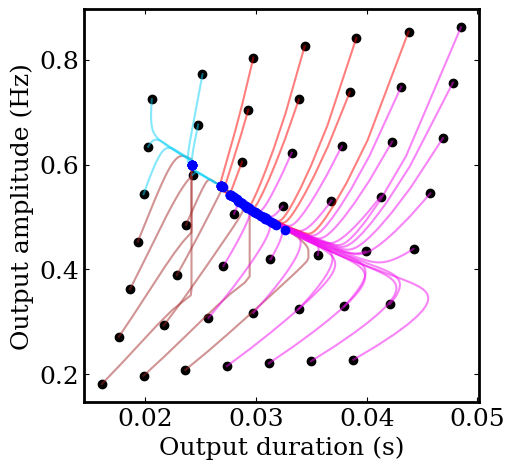

In [57]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(3, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[0]
    b_diff = weight_traj[-1] - weight_traj[1]
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
    else:
        color = '#f20df0' #light blue
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5, lw=1.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[3]], [traj[4]], color='black')
    axs.scatter([traj[-3]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Output duration (s)')
axs.set_ylabel('Output amplitude (Hz)')    

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/double_setpoint_amp_dur.png')
fig.savefig('./figures/double_setpoint_amp_dur.svg')

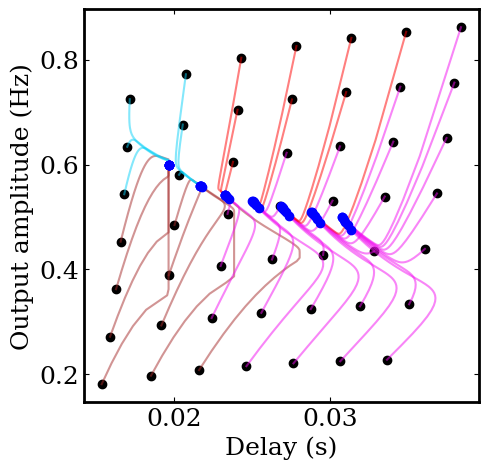

In [55]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(5, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[0]
    b_diff = weight_traj[-1] - weight_traj[1]

    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
    else:
        color = '#f20df0' #light blue
    
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5, lw=1.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[5]], [traj[4]], color='black')
    axs.scatter([traj[-1]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Delay (s)')
axs.set_ylabel('Output amplitude (Hz)')

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/double_setpoint_amp_delay.png')
fig.savefig('./figures/double_setpoint_amp_delay.svg')

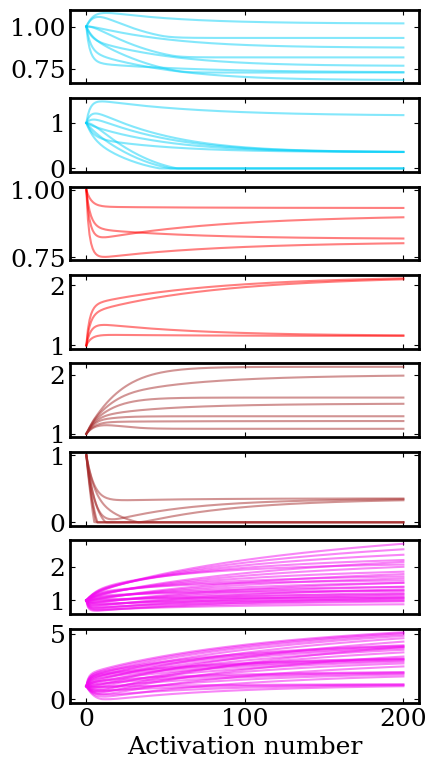

In [58]:
scale = 3
fig, axs = plt.subplots(8, 1, figsize=(1.5 * scale, 3 * scale), sharex=True)

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    weight_traj = weight_trajs[i_traj, :]
    
    w_diff = weight_traj[-2] - weight_traj[2]
    b_diff = weight_traj[-1] - weight_traj[3]
    
    w_idxs = np.arange(0, len(weight_traj), 2)
    b_idxs = np.arange(1, len(weight_traj), 2)
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
        graph_idx = 0
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
        graph_idx = 1
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
        graph_idx = 2
    else:
        color = '#f20df0' #light blue
        graph_idx = 3
    
    axs[graph_idx * 2].plot(np.arange(len(w_idxs)), weight_traj[w_idxs] / weight_traj[0] , color=color, alpha=0.5)
    axs[graph_idx * 2 + 1].plot(np.arange(len(b_idxs)), weight_traj[b_idxs] / weight_traj[1], color=color, alpha=0.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
#     axs.scatter([traj[5]], [traj[4]], color='black')
#     axs.scatter([traj[-1]], [traj[-2]], color='red', zorder=10)

axs[7].set_xlabel('Activation number')
# axs[3].set_ylabel('Coefficient magnitude')

for i in range(8):
    axs[i].tick_params(axis='both', which='both', direction='in', right=True, top=True)
#     axs[i].set_ylim(0, 2)
# plt.subplots_adjust(wspace=0, hspace=0.05)

# fig.savefig('./figures/double_setpoint_amp_delay.png')
# fig.savefig('./figures/double_setpoint_amp_delay.svg')

In [25]:
trajs_inh = copy(trajs)

IndexError: index 22 is out of bounds for axis 1 with size 20

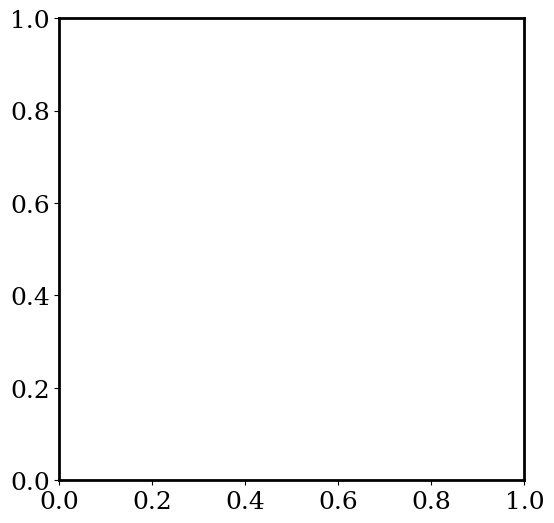

In [41]:
trajs = copy(trajs_inh)

tiling_size = 20

for i_cycle in range(n_cycles):
    if not i_cycle >= (n_cycles - 2):
        continue
#     if not (i_cycle % 1 == 0):
#         continue
    density = np.zeros((tiling_size, tiling_size))
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    for i_traj in range(trajs.shape[0]):
        traj = trajs[i_traj, :]
        density[int(traj[3 * i_cycle + 1] / 1.1 * tiling_size), int(traj[(3 * i_cycle + 2)] / 0.01 * tiling_size)] += 1
#     density /= density.sum()

    mappable = axs.matshow(density.T, vmin=0, vmax=50, cmap='hot')
    plt.colorbar(mappable, fraction=0.046, pad=0.04)
    axs.set_ylim(0, tiling_size - 1)
    axs.set_xlabel('Duration')
    axs.set_ylabel('Peak (Hz)')

In [59]:
T = 0.4 # Total duration of one network simulation
dt = 1e-4 # Timestep
t = np.linspace(0, T, int(T / dt))

def calc_alpha_func(tau_alpha):
    alpha_func_n_steps = int(10 * tau_alpha / dt)
    t_alpha = np.arange(0, alpha_func_n_steps) * dt
    return np.e * t_alpha / tau_alpha * np.exp(-t_alpha/tau_alpha)

def calc_response(inp, w, b, tau):
    r = np.zeros_like(t)
    s = np.zeros_like(t)

    for i in range(0, len(t) - 1):
        s[i+1] = s[i] + (w * inp[i] - s[i]) * dt / tau # update synaptic conductance as exponential filter of input
        r[i+1] = np.max([s[i+1] - b, 0])
    return r

w_0 = 1
b_0 = 0.1
tau = 5e-3
n_cycles = 200
w_set = 6e-7
b_set = 0.015
colors = get_ordered_colors('coolwarm', n_cycles)

trajs = np.zeros((100, (n_cycles + 1) * 3))
weight_trajs = np.zeros((100, (n_cycles + 1) * 2))

idx = 0
for tau_alpha in np.linspace(1e-3, 20e-3, 10):
    for a in np.linspace(0.01, 1, 10):
        r = np.zeros_like(t)
        w = copy(w_0)
        b = copy(b_0)
        
        inp = np.zeros_like(t)
        a_prime = a + np.random.normal(scale=0 * a)
        tau_alpha_prime = tau_alpha + np.random.normal(scale=0 * tau_alpha)
        inp_alpha = a_prime * calc_alpha_func(tau_alpha_prime)
        inp[:len(inp_alpha)] = inp_alpha
        
        m1_in = np.sum(inp * t) / np.sum(inp)
        
        traj = [tau_alpha, a, 0]
        weight_traj = [w, b]
        
        r_peak = a
        
        for i_cycle in range(n_cycles):
            r = calc_response(inp, w, b, tau)
        #     print(np.sum(np.square(r)) * dt)
            w += (100000 * (w_set - np.sum(np.square(r)) * np.square(dt)))
#             b += (2 * (np.sum(r) * dt - b_set))
            if w <= 0:
                w = 1e-8
            if b <= 0:
                b = 1e-8
                
            r_peak = np.max(r)
            m0 = np.sum(r) * dt
            m1_out = np.sum(r * t) * dt
            if m0 > 0:
                m1_out /= m0
        
            tau_out = 0
            if r_peak > 0:
                tau_out = m0 / r_peak
            traj.append(tau_out) 
            traj.append(r_peak)
            traj.append(m1_out)
            weight_traj.append(w)
            weight_traj.append(b)
        trajs[idx, :] = np.array(traj)
        weight_trajs[idx, :] = np.array(weight_traj)
        idx += 1

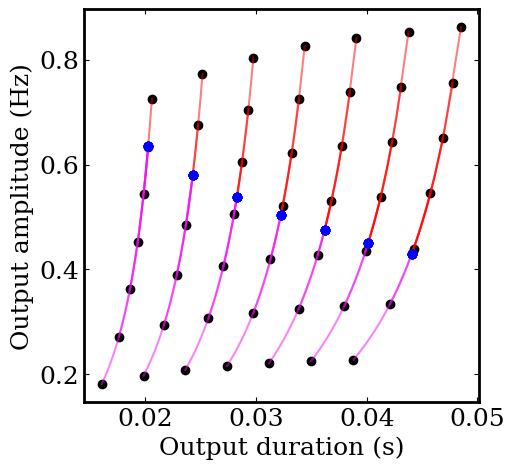

In [63]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(3, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[2]
    b_diff = weight_traj[-1] - weight_traj[3]
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
    else:
        color = '#f20df0' #light blue
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5, lw=1.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[3]], [traj[4]], color='black')
    axs.scatter([traj[-3]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Output duration (s)')
axs.set_ylabel('Output amplitude (Hz)')    

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/single_w_setpoint_amp_dur.png')
fig.savefig('./figures/single_w_setpoint_amp_dur.svg')

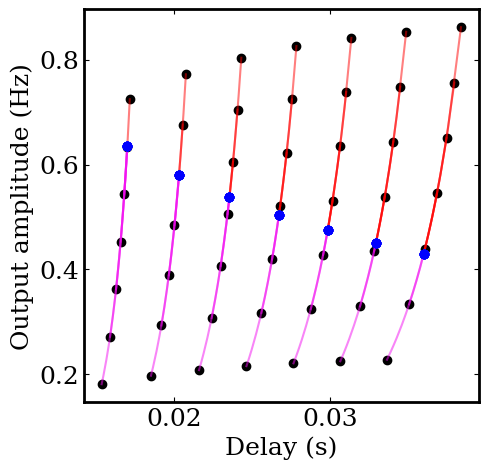

In [62]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(5, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[2]
    b_diff = weight_traj[-1] - weight_traj[3]
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8'
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'blue'
    else:
        color = '#f20df0'
    
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[5]], [traj[4]], color='black')
    axs.scatter([traj[-1]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Delay (s)')
axs.set_ylabel('Output amplitude (Hz)')

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/single_w_setpoint_amp_delay.png')
fig.savefig('./figures/single_w_setpoint_amp_delay.svg')

In [29]:
trajs_exc = copy(trajs)

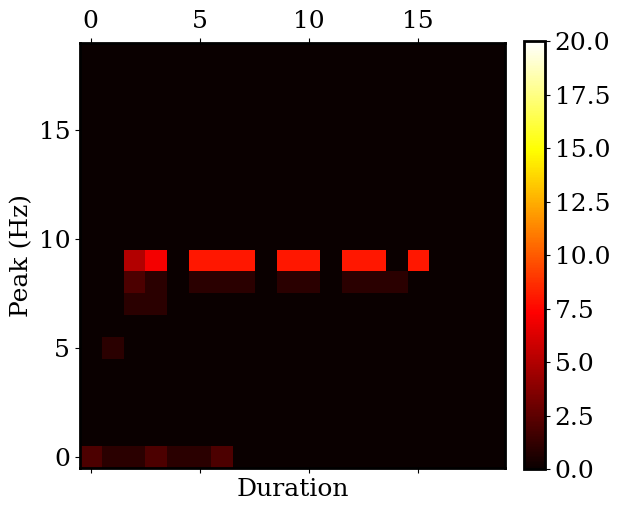

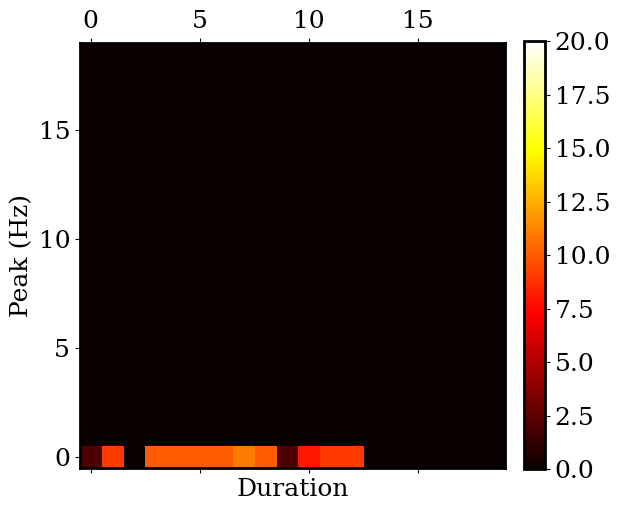

In [36]:
trajs = copy(trajs_exc)

tiling_size = 20

for i_cycle in range(n_cycles):
    if not i_cycle >= (n_cycles - 2):
        continue
#     if not (i_cycle % 1 == 0):
#         continue
    density = np.zeros((tiling_size, tiling_size))
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    for i_traj in range(trajs.shape[0]):
        traj = trajs[i_traj, :]
        density[int(traj[2 * i_cycle] / 0.06 * tiling_size), int(traj[(2 * i_cycle + 1)] / 1.1 * tiling_size)] += 1
#     density /= density.sum()

    mappable = axs.matshow(density.T, vmin=0, vmax=20, cmap='hot')
    plt.colorbar(mappable, fraction=0.046, pad=0.04)
    axs.set_ylim(-0.5, tiling_size - 1)
    axs.set_xlim(-0.5, tiling_size - 1)
    axs.set_xlabel('Duration')
    axs.set_ylabel('Peak (Hz)')

# Analytical approach
Imagine a single neuron modeled by 

$$r(t) = \left[w r_{\rm in}(t) - b \right]^+$$

In [59]:
def comp_integrals(w, b, a, T):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    I1 = wat * (T - t_star) + wat * tau_s * (exp_T - exp_t_star) - b * (T - t_star) + wat * tau_s * (1 - np.exp(T / tau_s)) * (exp_t_star_star - exp_T) - b * (t_star_star - T)
    
    I2 = np.square(wat - b) * (T - t_star)
    I2 += 2 * wat * tau_s * (wat - b) * (exp_T - exp_t_star)
    I2 += -np.square(wat) * tau_s / 2 * (np.square(exp_T) - np.square(exp_t_star))
    I2 += np.square(b) * (t_star_star - T)
    I2 += 2 * b * tau_s * wat * (np.exp(T/tau_s) - 1) * (exp_t_star_star - exp_T)
    I2 += -tau_s/2 * np.square(wat * (np.exp(T/tau_s) - 1)) * (np.square(exp_t_star_star) - np.square(exp_T))
    
    I1 = np.where(wat * (1 - exp_T) > b, I1, 0)
    I2 = np.where(wat * (1 - exp_T) > b, I2, 0)
    
    return I1, I2

def comp_lags_and_peaks(w, b, a, T):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    I1 = wat * (T - t_star) + wat * tau_s * (exp_T - exp_t_star) - b * (T - t_star) + wat * tau_s * (1 - np.exp(T / tau_s)) * (exp_t_star_star - exp_T) - b * (t_star_star - T)
    M1 = 0.5 * (wat - b) * (np.square(T) - np.square(t_star)) + wat * tau_s * ((T + tau_s) * exp_T - (t_star + tau_s) * exp_t_star) + wat * tau_s * (np.exp(T / tau_s) - 1) * ((T + tau_s) * exp_T - (t_star_star + tau_s) * exp_t_star_star) - 0.5 * b * (np.square(t_star_star) - np.square(T))
    
    lags = np.where(wat * (1 - exp_T) > b, M1 / I1, 0)
    peaks = np.where(wat * (1 - exp_T) > b, wat * (1 - exp_T) - b, 0)
    
    return lags, peaks
    
def comp_changes(w, b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    I1, I2 = comp_integrals(w, b, a, T)
    delta_b = b_rate * (b_coef_I1 * I1 + b_coef_I2 * I2 - b_set)
    delta_w = w_rate * (w_set - w_coef_I2 * I2 - w_coef_I1 * I1)
    return delta_w, delta_b

def comp_changes_arr(x, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return np.array(comp_changes(x[0], x[1], a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2))

def comp_changes_fixed_b(x, b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    delta_w, delta_b = np.array(comp_changes(x[0], b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2))
    return np.array(delta_w)

def comp_changes_fixed_w(x, w, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    delta_w, delta_b = comp_changes(w, x[0], a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
    return np.array(delta_b)

def fixed_point_eq(a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return partial(comp_changes_arr, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

def fixed_point_eq_fixed_b(b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return partial(comp_changes_fixed_b, b=b, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

def fixed_point_eq_fixed_w(w, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return partial(comp_changes_fixed_w, w=w, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

def find_fixed_point(a, T, w_set, b_set, w_rate=1, b_rate=1, w_coef_I1=1, w_coef_I2=1, b_coef_I1=1, b_coef_I2=1, w=None, b=None):
    valid_solns_mask = np.zeros(len(a.flatten()), dtype=bool)
    solns = []
    
    guess_solns_fixed_bias = np.array([
        [30],
        [120],
    ])
    
    if w_rate != 0 and b_rate != 0:
    
        guess_solns = np.array([
            [30, 1],
            [120, 1],
            [30, 0.1],
            [120, 0.1],
        ])
    
        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq(a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            soln_found = False
            for i_x in range(guess_solns.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(2)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
                        
            f = fixed_point_eq_fixed_b(0, a_i, T_i, w_set, b_set, w_rate, 0, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            for i_x in range(guess_solns_fixed_bias.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns_fixed_bias[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(1)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(np.array([soln[0], 0]))
                        soln_found = True
    
    elif w_rate != 0:

        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq_fixed_b(b, a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            soln_found = False
            for i_x in range(guess_solns_fixed_bias.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns_fixed_bias[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(1)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
                        
    else:
        guess_solns_ignore_weight = np.array([
            [1],
            [0.1],
        ])
    
        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq_fixed_w(w, a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            soln_found = False
            for i_x in range(guess_solns_ignore_weight.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns_ignore_weight[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(1)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
            
    solns = np.array(solns)
    return solns, valid_solns_mask

def comp_derivatives(w, b, a, T):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    dt_star_dw = tau_s / (w * (1 - wat/b))
    dexp_t_star_dw = b / (np.square(w) * a * tau_s)
    dt_star_star_dw = tau_s / w
    dexp_t_star_star_dw = -b / (w * wat * (np.exp(T/tau_s) - 1))
    
    dt_star_db = tau_s / (wat - b)
    dexp_t_star_db = -1 / wat
    dt_star_star_db = -tau_s / b
    dexp_t_star_star_db = 1 / (wat * (np.exp(T/tau_s) - 1))
    
    dI1_dw = a * tau_s * (T - t_star) - (wat - b) * dt_star_dw + a * np.square(tau_s) * (exp_T - exp_t_star)
    dI1_dw += -wat * tau_s * dexp_t_star_dw
    dI1_dw += (1 - np.exp(T/tau_s)) * (a * np.square(tau_s) * (exp_t_star_star - exp_T) + wat * tau_s * dt_star_star_dw)
    dI1_dw += -b * dt_star_star_dw
    
    dI1_db = -b * (T - t_star) - (wat - b) * dt_star_db - wat * tau_s * dexp_t_star_db
    dI1_db += wat * tau_s * (1 - np.exp(T/tau_s)) * dexp_t_star_star_db - (t_star_star - T) - b * dt_star_star_db
    
    dI2_dw = 2 * (wat - b) * a * tau_s * (T - t_star) - np.square(wat - b) * dt_star_dw
    dI2_dw += 2 * a * np.square(tau_s) * (wat - b) * (exp_T - exp_t_star)
    dI2_dw += 2 * wat * tau_s * (a * tau_s * (exp_T - exp_t_star) - (wat - b) * dexp_t_star_dw)
    dI2_dw += w * np.square(a) + tau_s**3 * (np.square(exp_T) - np.square(exp_t_star))
    dI2_dw += np.square(a * tau) * tau_s**3 * exp_t_star * dexp_t_star_dw + np.square(b) * dt_star_star_dw
    dI2_dw += (np.exp(T/tau_s) - 1) * (2 * b * a * np.square(tau_s) * ((exp_t_star_star - exp_T) + w * dexp_t_star_star_dw))
    dI2_dw += -(np.exp(T/tau_s) - 1) * np.square(a) * tau_s**3 * w * ((np.square(exp_t_star_star) - np.square(exp_T)) + w * exp_t_star_star * dexp_t_star_star_dw)
    
    dI2_db = -2 * (wat - b) * (T - t_star) - np.square(wat - b) * dt_star_db - 2 * wat * tau_s * (exp_T - exp_t_star)
    dI2_db += -2 * wat * tau_s * (wat - b) * dexp_t_star_db + np.square(wat) * tau_s * exp_t_star * dexp_t_star_db
    dI2_db += 2 * b * (t_star_star - T) + np.square(b) * dt_star_star_db
    dI2_db += (np.exp(T/tau_s) - 1) * (2 * wat * tau_s * (exp_t_star_star - exp_T + b * dexp_t_star_star_db) + np.square(wat) * tau_s * exp_t_star_star * dexp_t_star_star_db)
    
    return dI2_dw, dI2_db, dI1_dw, dI1_db

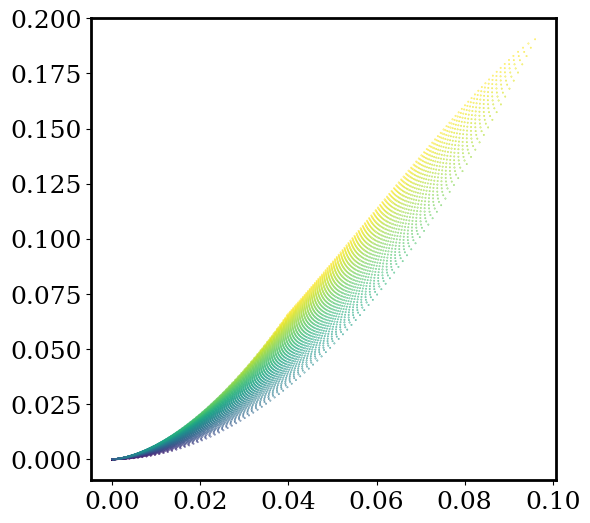

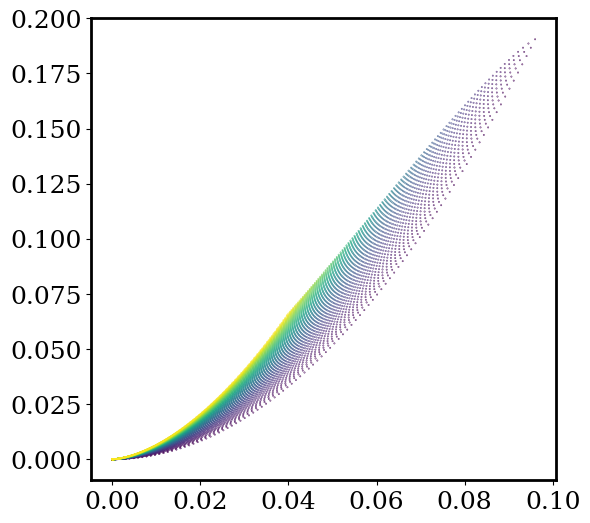

In [57]:
T = 0.012
a = 10
tau_s = 0.02

w, b = np.meshgrid(np.linspace(0, 40, 100), np.linspace(0, 1, 100))

I1, I2 = comp_integrals(w, b, a, T)



scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(I1, I2, s=0.1, c=w)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(I1, I2, s=0.1, c=b)



[49.90795997  0.81067903]
(array([-4.99079613e+03, -1.14390937e-02]), array([[-1.00000000e+00, -2.92286292e-06],
       [ 6.40075156e-08, -1.00000000e+00]]))
[33.05118564  0.27016214]
(array([-3.30511883e+03, -9.14229144e-03]), array([[-1.00000000e+00, -5.70714193e-06],
       [ 1.20574950e-07, -1.00000000e+00]]))
[23.91036855  0.        ]
(2391.0371983252094, nan, 0.0004677852563691599, nan)


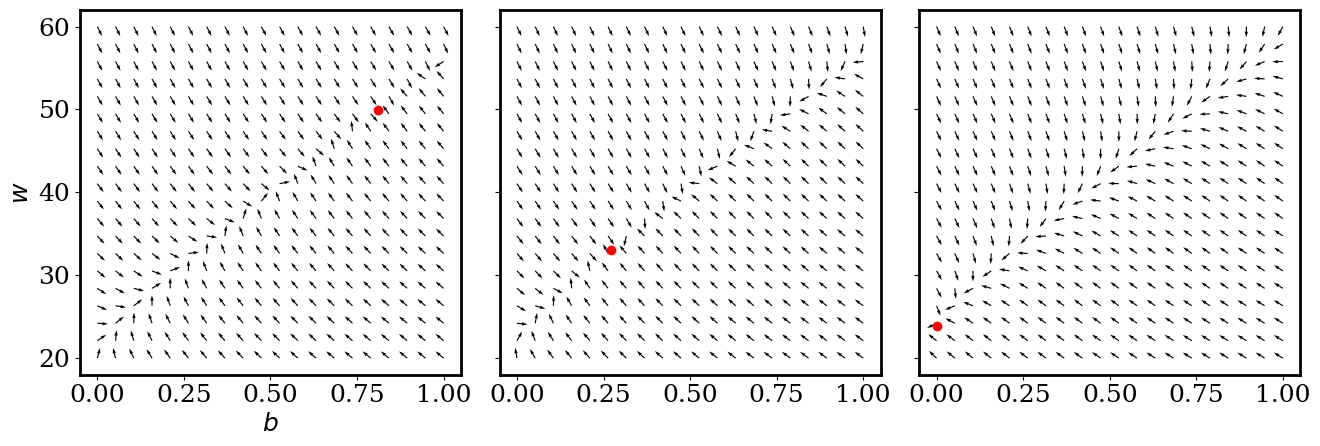

In [65]:
T = np.array([0.012])
a = np.array([10])
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(20, 60, 20), np.linspace(0, 1, 20))

# panel 1
w_set = 0.0075
b_set = 0.009

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, 0, 1, 1, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0])
derivs_mat = np.array([[-derivs[0], -derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs_mat))

# panel 1
w_set = 0.0075
b_set = 0.01

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, 0, 1, 1, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0])
derivs = np.array([[-derivs[0], -derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs))

# panel 1
w_set = 0.0075
b_set = 0.012

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, 0, 1, 1, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

print(comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0]))


fig.tight_layout()



[22.13287269  0.13603203]
(array([ 4.41325333, -4.4280972 ]), array([[ 0.0020005 , -0.00199417],
       [ 0.999998  ,  0.99999801]]))
[28.75034296  0.30762555]
(array([ 4.90104547, -4.91512568]), array([[ 0.00170946, -0.00170482],
       [ 0.99999854,  0.99999855]]))
[37.37546752  0.5513438 ]
(array([ 5.91678599, -5.92980023]), array([[ 0.00158646, -0.00158315],
       [ 0.99999874,  0.99999875]]))


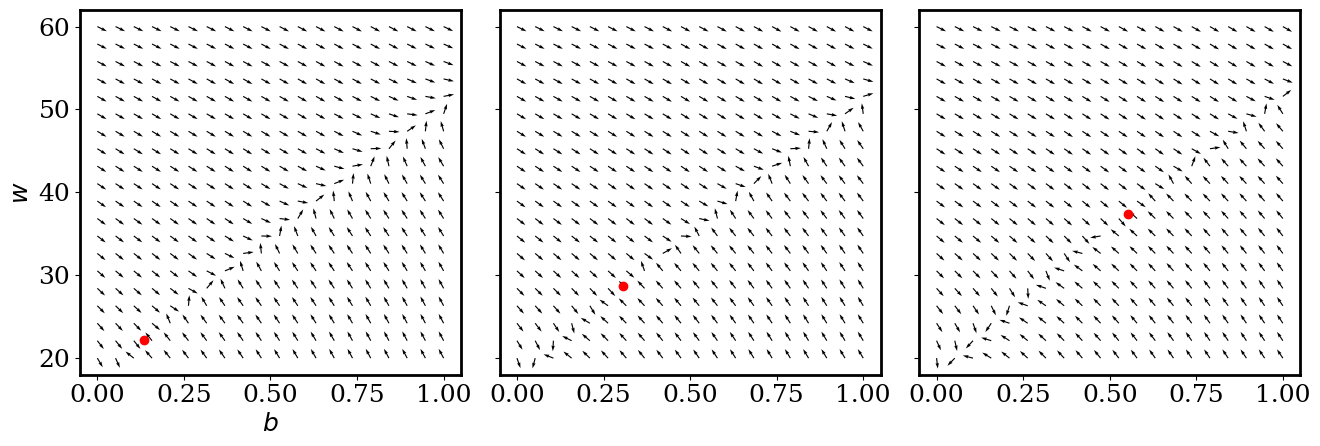

In [67]:
T = np.array([0.012])
a = np.array([10])
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(20, 60, 20), np.linspace(0, 1, 20))

# panel 1
w_set = 0.0075
b_set = 0.004

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1


delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0])
derivs_mat = np.array([[-derivs[2], -derivs[3]], [derivs[0], derivs[1]]])
print(np.linalg.eig(derivs_mat))

# panel 1
w_set = 0.0075
b_set = 0.0045

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0])
derivs_mat = np.array([[-derivs[2], -derivs[3]], [derivs[0], derivs[1]]])
print(np.linalg.eig(derivs_mat))

# panel 1
w_set = 0.0075
b_set = 0.005

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0])
derivs_mat = np.array([[-derivs[2], -derivs[3]], [derivs[0], derivs[1]]])
print(np.linalg.eig(derivs_mat))

fig.tight_layout()


[17.46166428  0.        ]
[36.66604635  0.59923393]
[17.46166428  0.        ]


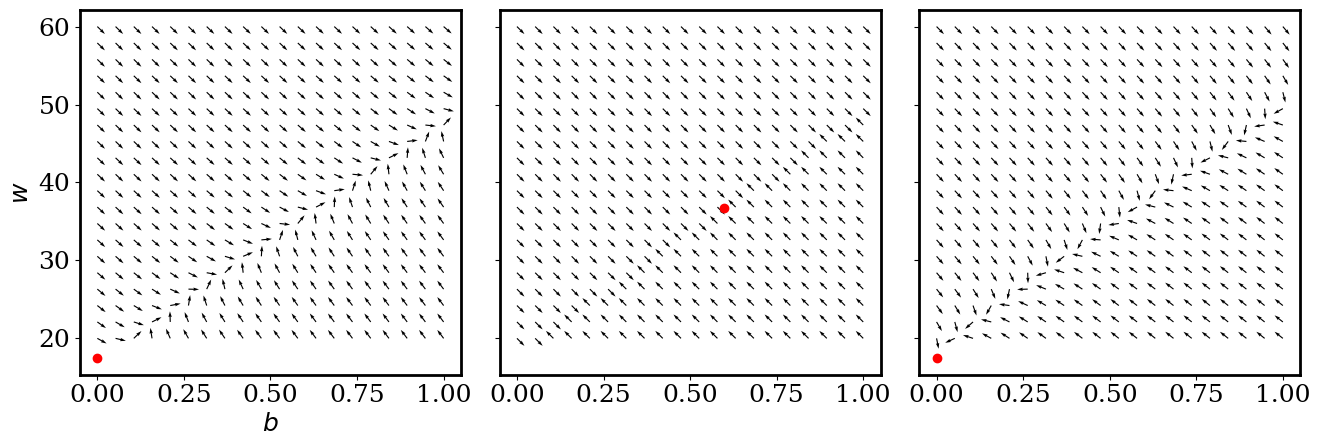

In [49]:
T = np.array([0.012])
a = np.array([10])
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(20, 60, 20), np.linspace(0, 1, 20))

# panel 1
w_set = 0.004
b_set = 0.003

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 0
b_coef_I2 = 1


delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
w_set = 0.004
b_set = 0.004

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

# panel 1
w_set = 0.004
b_set = 0.005

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

fig.tight_layout()

[46.17165893  0.68817587]
[26.25204146  0.06613828]
[23.91036855  0.        ]


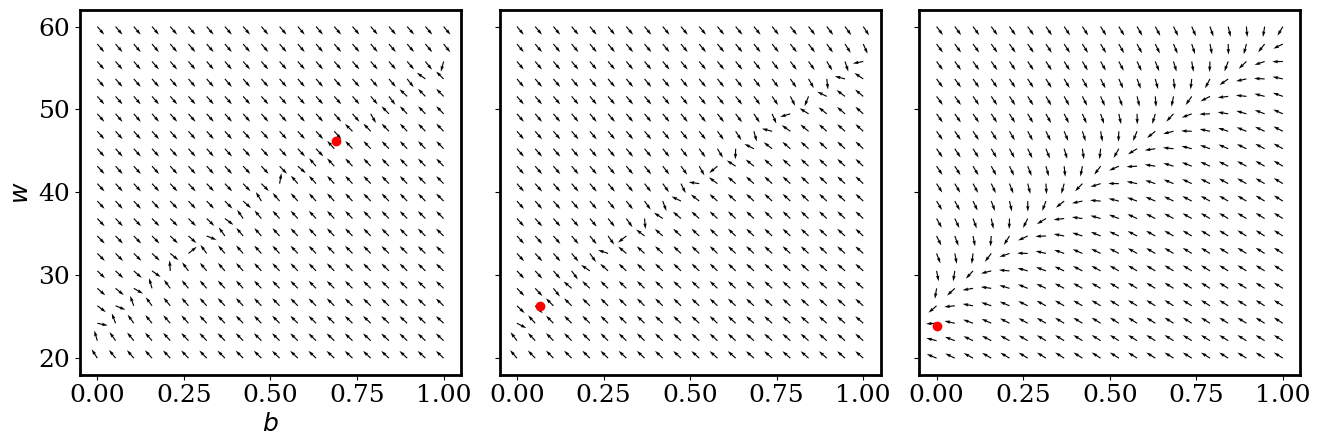

In [68]:
T = np.array([0.012])
a = np.array([10])
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(20, 60, 20), np.linspace(0, 1, 20))

# panel 1
w_set = 0.0075
b_set = 0.008

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 0.3
b_coef_I2 = 0.7


delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
w_set = 0.0075
b_set = 0.0085

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

# panel 1
w_set = 0.0075
b_set = 0.012

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

fig.tight_layout()

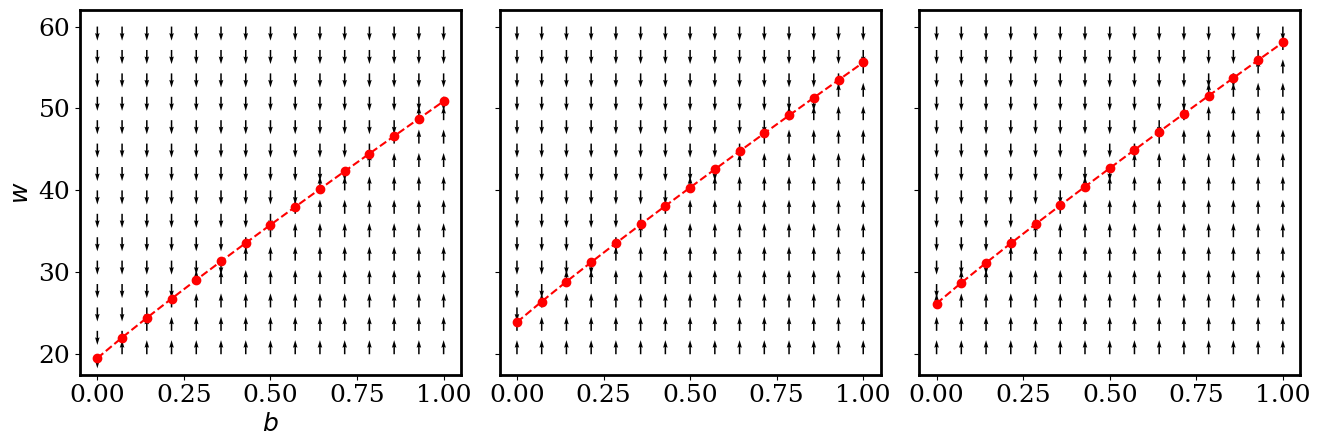

In [34]:
T = np.array([0.012])
a = np.array([10])
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
b_vals = np.linspace(0, 1, 15)
w, b = np.meshgrid(np.linspace(20, 60, 15), b_vals)

# panel 1
w_set = 0.005
b_set = 0

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I1=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[0].plot(b_vals, w_fixed, '--', color='red')
axs[0].scatter(b_vals, w_fixed, color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
w_set = 0.0075
b_set = 0

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I1=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[1].plot(b_vals, w_fixed, '--', color='red')
axs[1].scatter(b_vals, w_fixed, color='red')

# panel 1
w_set = 0.009
b_set = 0

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I1=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[2].plot(b_vals, w_fixed, '--', color='red')
axs[2].scatter(b_vals, w_fixed, color='red')

fig.tight_layout()

Now that we have a technique for finding the fixed points of the $\left(w, b\right)$ given the input, we can find the stable responses for many different $\left(T, a\right)$.

In [58]:
tau_s = 0.004
w_set = 0.008
b_set = 0.011
a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.003, 0.02, 100))

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set)
np.count_nonzero(valid_solns_mask)
print(fixed_points)


[[374.87828041   0.        ]
 [343.63842371   0.        ]
 [317.20469881   0.        ]
 ...
 [ 33.36890631   1.7384536 ]
 [ 33.06276955   1.7384536 ]
 [ 32.76219892   1.7384536 ]]


9991
[35.33178316  1.7384536 ]
5.118127701134928e-06 0.041896208648005535


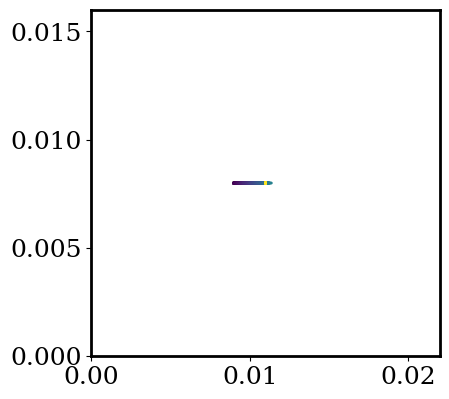

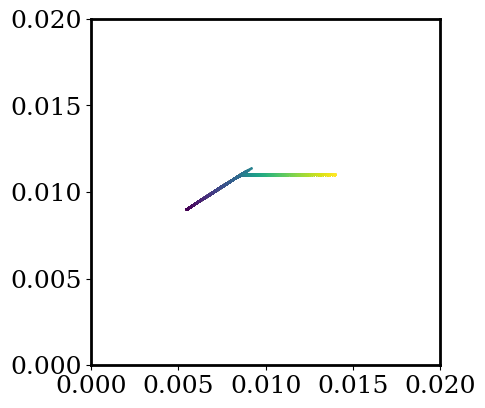

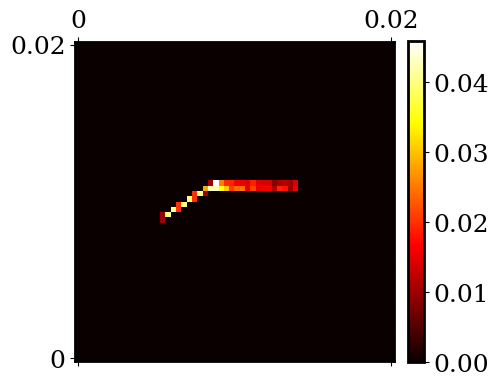

In [59]:
# print(fixed_points[:, 0].max())
# print(fixed_points[:, 1].max())
I1, I2 = comp_integrals(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])   
print(lags.argmax())

print(fixed_points[lags.argmax(), :])

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(I1, I2, s=1, c=T.flatten()[valid_solns_mask])
axs.set_xlim(0, 2 * b_set)
axs.set_ylim(0, 2 * w_set)

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(lags, I1, s=1, c=T.flatten()[valid_solns_mask])
lag_max = 0.02
lag_min = 0
I1_max = 0.02
I1_min = 0
axs.set_ylim(I1_min, I1_max)
axs.set_xlim(lag_min, lag_max)

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, i1 in zip(lags, I1):
    i_I1 = int((i1 - I1_min) / (I1_max - I1_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_I1, i_lag] += 1
    
density = density / density.sum()

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([I1_min, I1_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)

print(np.var(lags), np.var(peaks))


In [60]:
b_fixed = 0.2
fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b_rate=0, b=b_fixed)

10000
6.934360102966214e-06 0.0748989780416336


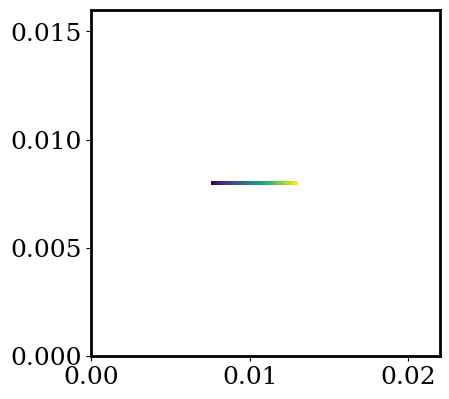

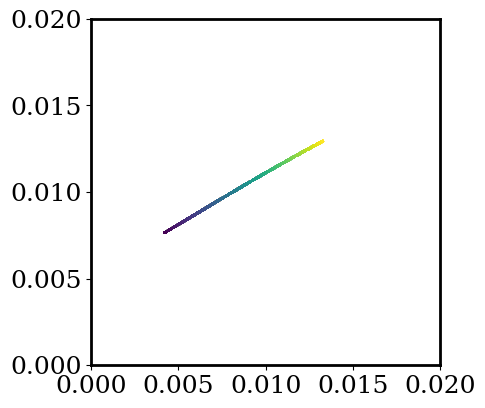

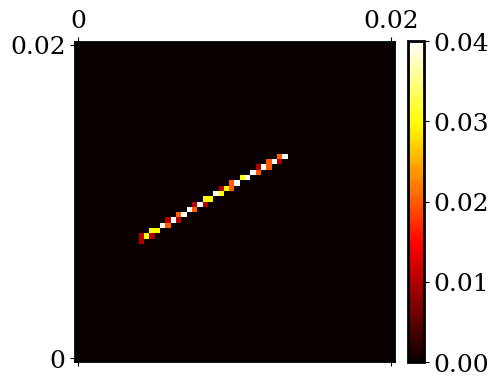

In [61]:
print(np.count_nonzero(valid_solns_mask))

I1, I2 = comp_integrals(fixed_points[:, 0], b_fixed, a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], b_fixed, a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])   

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(I1, I2, s=1, c=T.flatten()[valid_solns_mask])
axs.set_xlim(0, 2 * b_set)
axs.set_ylim(0, 2 * w_set)

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(lags, I1, s=1, c=T.flatten()[valid_solns_mask])
lag_max = 0.02
lag_min = 0
I1_max = 0.02
I1_min = 0
axs.set_ylim(I1_min, I1_max)
axs.set_xlim(lag_min, lag_max)

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, i1 in zip(lags, I1):
    i_I1 = int((i1 - I1_min) / (I1_max - I1_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_I1, i_lag] += 1
    
density = density / density.sum()

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([I1_min, I1_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)

print(np.var(lags), np.var(peaks))


In [720]:
w_fixed = 30
fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_rate=0, w=w_fixed)


3415
2.0539057758204025e-06 0.05758750451614794


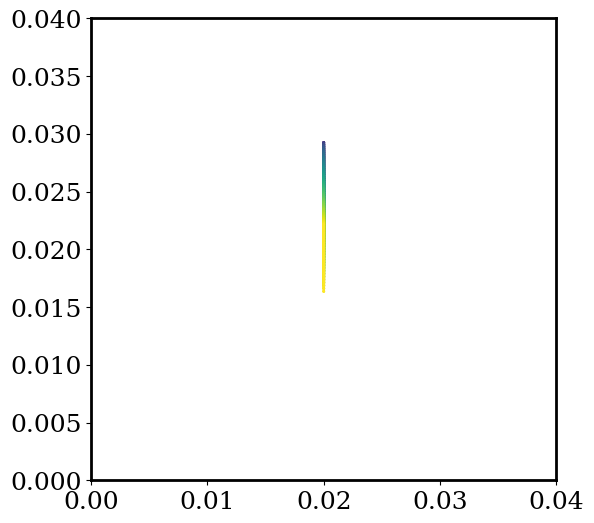

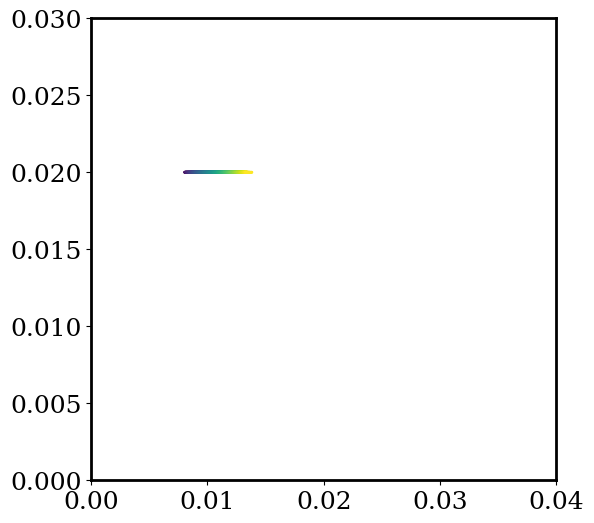

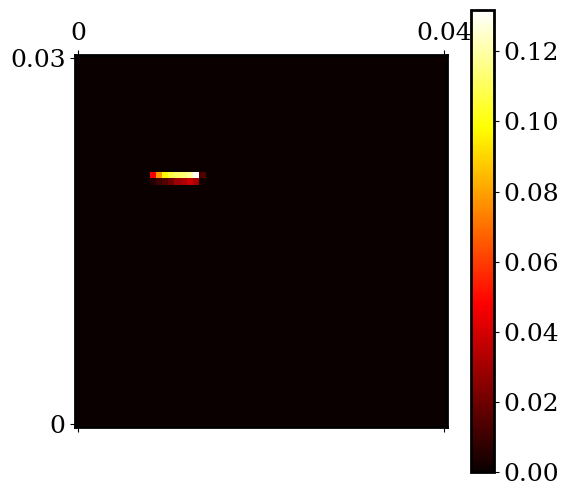

In [722]:
print(np.count_nonzero(valid_solns_mask))

I1, I2 = comp_integrals(w_fixed, fixed_points[:, 0], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
lags, peaks = comp_lags_and_peaks(w_fixed, fixed_points[:, 0], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])   

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(I1, I2, s=1, c=T.flatten()[valid_solns_mask])
axs.set_xlim(0, 2 * b_set)
axs.set_ylim(0, 2 * w_set)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(lags, I1, s=1, c=T.flatten()[valid_solns_mask])
lag_max = 0.04
lag_min = 0
I1_max = 0.03
I1_min = 0
axs.set_ylim(I1_min, I1_max)
axs.set_xlim(lag_min, lag_max)

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, i1 in zip(lags, I1):
    i_I1 = int((i1 - I1_min) / (I1_max - I1_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_I1, i_lag] += 1
    
density = density / density.sum()

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([I1_min, I1_max])
fig.colorbar(cbar)

print(np.var(lags), np.var(peaks))

[[0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]
 [0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667

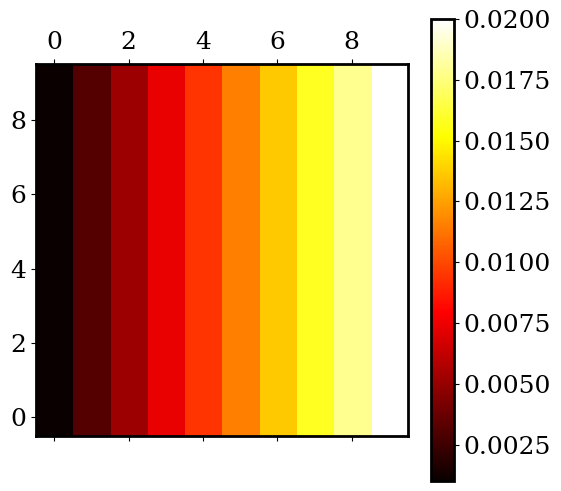

In [535]:
w_set_all, b_set_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.linspace(0.001, 0.02, 10))
print(w_set_all)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(w_set_all, cmap='hot', origin='lower')
plt.colorbar(cbar)

In [753]:
tau_s = 0.004
a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.006, 0.02, 100))

w_set_all, b_set_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.linspace(0.001, 0.02, 10))

all_vars = []
all_vars_I1s = []
valid_soln_counts = []

for w_set, b_set in zip(w_set_all.flatten(), b_set_all.flatten()):
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set)
    solns_count = np.count_nonzero(valid_solns_mask)
    valid_soln_counts.append(solns_count)
    
    if solns_count == 0:
        all_vars.append(np.nan)
    else:
        if len(fixed_points.shape) == 1:
            fixed_points = fixed_points.reshape(1, 2)

        I1, I2 = comp_integrals(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
        lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
        all_vars_I1s.append(np.var(I1))
        all_vars.append(np.var(lags))
    
av = np.array(all_vars).reshape(10, 10)
mvI1s = np.array(all_vars_I1s).reshape(10, 10)
vcn = np.array(valid_soln_counts).reshape(10, 10)


KeyboardInterrupt



In [ ]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(av, cmap='hot', origin='lower', vmin=0, vmax=2 * np.nanmax(av))
plt.colorbar(cbar)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(vcn, cmap='hot', origin='lower', vmin=0, vmax=100**2)
plt.colorbar(cbar)

In [751]:
tau_s = 0.004
a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.006, 0.02, 100))

w_set_all, b_set_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.ones(1))
b_fixed = 0.2
print(w_set_all)

all_vars = []
all_vars_I1s = []
valid_soln_counts = []

for w_set, b_set in zip(w_set_all.flatten(), b_set_all.flatten()):
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b_rate=0, b=b_fixed)
    solns_count = np.count_nonzero(valid_solns_mask)
    valid_soln_counts.append(solns_count)
    
    if solns_count == 0:
        all_vars.append(np.nan)
    else:
        if len(fixed_points.shape) == 1:
            fixed_points = fixed_points.reshape(1, 2)
        print(fixed_points[:, 0])
        I1, I2 = comp_integrals(fixed_points[:, 0], b_fixed, a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
        lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], b_fixed, a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
        all_vars.append(np.var(lags))
        all_vars_I1s.append(np.var(I1))
    
av2 = np.array(all_vars).reshape(10, 1)
vI1s2 = np.array(all_mean_I1s).reshape(10, 1)
vcn2 = np.array(valid_soln_counts).reshape(10, 1)

[[0.001      0.00311111 0.00522222 0.00733333 0.00944444 0.01155556
  0.01366667 0.01577778 0.01788889 0.02      ]]
[118.46220609 108.59035558 100.2372513  ...   6.10033345   6.04436709
   5.9894183 ]
[176.25538757 161.5674386  149.13917409 ...   8.58680919   8.50803112
   8.43068539]
[215.2530918  197.31533415 182.13723152 ...  10.26916184  10.17494935
  10.08244981]
[246.74095234 226.17920632 208.78080583 ...  11.62875693  11.52207109
  11.41732498]
[273.87171094 251.04906836 231.73760157 ...  12.80076786  12.68332962
  12.56802662]
[298.06647463 273.22760174 252.21009392 ...  13.84625304  13.7192232
  13.59450298]
[320.11000796 293.43417396 270.86231443 ...  14.79897216  14.66320177
  14.52989994]
[340.48981183 312.11566084 288.10676385 ...  15.6799146   15.53606217
  15.39482525]
[359.53323886 329.57213562 304.22043288 ...  16.5031832   16.35177785
  16.20312532]
[377.47266725 346.01661165 319.39994921 ...  17.27879386  17.12027281
  16.96463397]


(10, 10)
[[5.21044455e-06]
 [4.85100959e-06]
 [4.72618772e-06]
 [4.65608540e-06]
 [4.60934346e-06]
 [4.57519357e-06]
 [4.54877151e-06]
 [4.52750606e-06]
 [4.50988981e-06]
 [4.49497123e-06]]


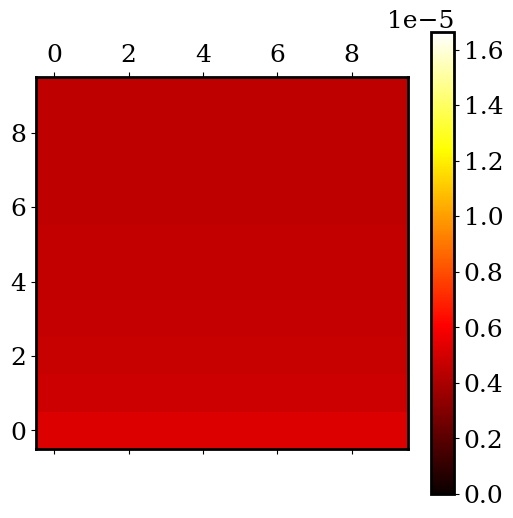

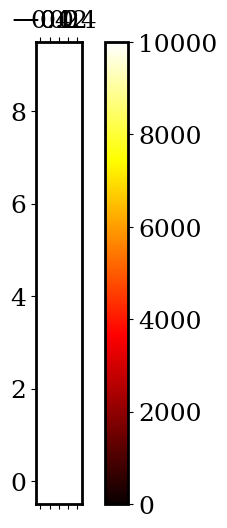

In [746]:
av2_stacked = np.concatenate([av2 for i in range(10)], axis=1)

print(av2_stacked.shape)

print(av2)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(av2_stacked, cmap='hot', origin='lower', vmin=0, vmax=np.nanmax(av))
plt.colorbar(cbar)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(vcn2, cmap='hot', origin='lower', vmin=0, vmax=100**2)
plt.colorbar(cbar)

In [524]:
tau_s = 0.004
a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.006, 0.02, 100))

w_set_all, b_set_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.linspace(0.001, 0.02, 10))

all_vars = []
valid_soln_counts = []

for w_set, b_set in zip(w_set_all.flatten(), b_set_all.flatten()):
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_rate=0)
    solns_count = np.count_nonzero(valid_solns_mask)
    valid_soln_counts.append(solns_count)
    
    if solns_count == 0:
        all_vars.append(np.nan)
    else:
        if len(fixed_points.shape) == 1:
            fixed_points = fixed_points.reshape(1, 2)

        I1, I2 = comp_integrals(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
        lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
        all_vars.append(np.var(lags))
    
av3 = np.array(all_vars).reshape(10, 10)
vcn3 = np.array(valid_soln_counts).reshape(10, 10)

[[10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]
 [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000]]


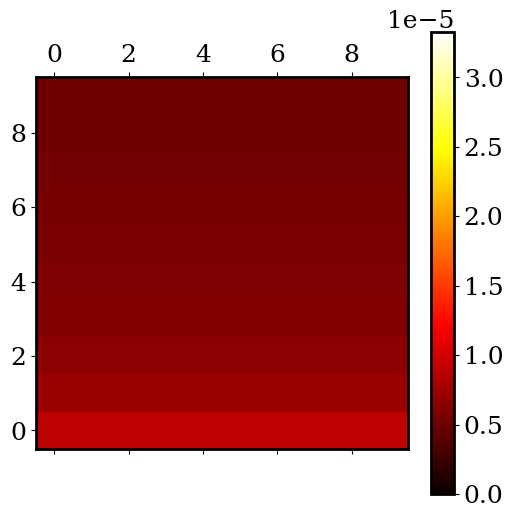

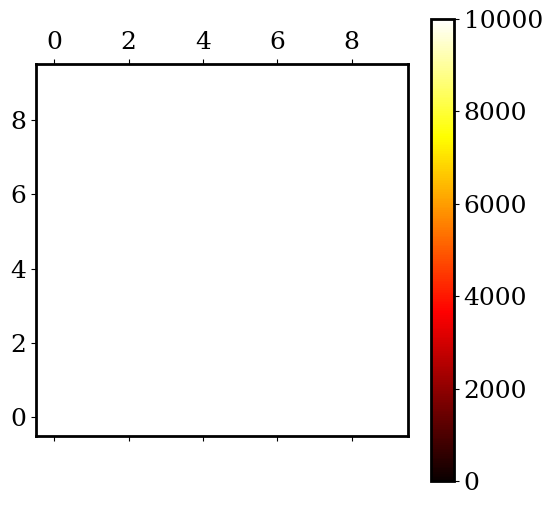

In [525]:
# av3 = np.array(all_vars).reshape(10, 10)
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(av3, cmap='hot', origin='lower', vmin=0, vmax=2 * np.nanmax(av))
plt.colorbar(cbar)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(vcn3, cmap='hot', origin='lower', vmin=0, vmax=100**2)
plt.colorbar(cbar)

print(vcn3)

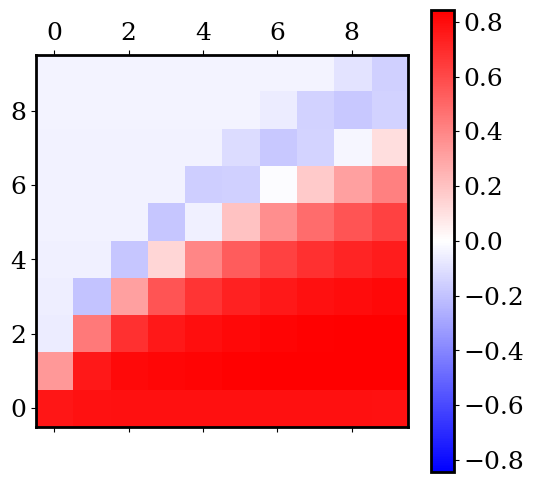

In [775]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
diffs = (np.sqrt(av) - np.sqrt(av2_stacked)) / np.sqrt(av2_stacked)
m = np.abs(diffs).max()
cbar = axs.matshow(diffs, cmap='bwr', origin='lower', vmax=m, vmin=-m)
plt.colorbar(cbar)